# Cluster Analysis

This notebook attempts to run a cluster analysis based on patient journey time spent at each machine. It pulls heavily from this [notebook](https://colab.research.google.com/drive/1UIWjSp8NJHQWAiEfqzCJkolv1FhuQ0XF).

## Package and Function Load In

In [35]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos
!pip install pysal

In [36]:
#@title
import os
import io
import glob
from google.colab import files
import statsmodels.formula.api as smf
import scipy
import csv
import datetime
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy.stats as sps
from matplotlib.ticker import AutoMinorLocator
pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']



In [37]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from math import ceil

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

## File Load In

In this section the files generated from each of the machine notebooks and the full phase notebook must be loaded in for analysis.

In [38]:
AFdf = pd.read_csv('AFdf.csv')
HFAdf = pd.read_csv('HFAdf.csv')
OCTdf = pd.read_csv('OCTdf.csv')
ORAdf = pd.read_csv('ORAdf.csv')
WFdf = pd.read_csv('WFdf.csv')
phase2df = pd.read_csv('phase2df.csv')

## Data Cleaning and Formatting

In [39]:
AFdf = AFdf.rename(columns={'visit_length_minutes': 'AF_visit_length_minutes'})
HFAdf = HFAdf.rename(columns={'visit_length_minutes': 'HFA_visit_length_minutes'})
OCTdf = OCTdf.rename(columns={'visit_length_minutes': 'OCT_visit_length_minutes'})
ORAdf = ORAdf.rename(columns={'visit_length_minutes': 'ORA_visit_length_minutes'})
WFdf = WFdf.rename(columns={'visit_length_minutes': 'WF_visit_length_minutes'})

In [40]:
AFdfmerge = AFdf[['Patient', 'AF_visit_length_minutes']].copy()
HFAdfmerge = HFAdf[['Patient', 'HFA_visit_length_minutes']].copy()
OCTdfmerge = OCTdf[['Patient', 'OCT_visit_length_minutes']].copy()
ORAdfmerge = ORAdf[['Patient', 'ORA_visit_length_minutes']].copy()
WFdfmerge = WFdf[['Patient', 'WF_visit_length_minutes']].copy()

## Merging the different files together on Patient

In [41]:
firstmerge = phase2df.merge(AFdfmerge, how = 'inner', on='Patient')
firstmerge.count()

Patient                    829
newfrom                    829
newto                      829
visit_length               829
dayofweek                  829
tod                        829
hour                       829
condition                  829
visit_length_minutes       829
AF_visit_length_minutes    829
dtype: int64

In [42]:
secondmerge = firstmerge.merge(HFAdfmerge, how = 'inner', on='Patient')
secondmerge.count()

Patient                     696
newfrom                     696
newto                       696
visit_length                696
dayofweek                   696
tod                         696
hour                        696
condition                   696
visit_length_minutes        696
AF_visit_length_minutes     696
HFA_visit_length_minutes    696
dtype: int64

In [43]:
thirdmerge = secondmerge.merge(OCTdfmerge, how = 'inner', on ='Patient')
thirdmerge.count()

Patient                     692
newfrom                     692
newto                       692
visit_length                692
dayofweek                   692
tod                         692
hour                        692
condition                   692
visit_length_minutes        692
AF_visit_length_minutes     692
HFA_visit_length_minutes    692
OCT_visit_length_minutes    692
dtype: int64

## WF versus No WF in Final Merge

As you can see below before merging with WF there are 640 records however in the next section once the merge happens with the WF machine the records fall to 270. 

Please note that all subsequent analysis is done not using the WF machine so that there are more records included.

In [44]:
noWFdf = thirdmerge.merge(ORAdfmerge, how = 'inner', on ='Patient')
noWFdf.count()

Patient                     640
newfrom                     640
newto                       640
visit_length                640
dayofweek                   640
tod                         640
hour                        640
condition                   640
visit_length_minutes        640
AF_visit_length_minutes     640
HFA_visit_length_minutes    640
OCT_visit_length_minutes    640
ORA_visit_length_minutes    640
dtype: int64

In [45]:
finalmerge = noWFdf.merge(WFdfmerge, how = 'inner', on ='Patient')
finalmerge.count()

Patient                     270
newfrom                     270
newto                       270
visit_length                270
dayofweek                   270
tod                         270
hour                        270
condition                   270
visit_length_minutes        270
AF_visit_length_minutes     270
HFA_visit_length_minutes    270
OCT_visit_length_minutes    270
ORA_visit_length_minutes    270
WF_visit_length_minutes     270
dtype: int64

## Data Exploration

The next section ums the visit length in each machine and then compares it to the total visit length from the phase2df.csv file. 

An issue arises because the sum for a number of the rows is greater than the entire journey length which is impossible. The reason for this is because the spatial resolution isn't fine enough so it pulls people into machines when they may be walking by it not necessarily when they're sitting in the machine. 

Future work would benefit by saying that the patients have to be in a location for a set number of data points so that they're actually there and not just walking by.

In [46]:
noWFdf['sum'] = noWFdf['AF_visit_length_minutes'] + noWFdf['HFA_visit_length_minutes'] + noWFdf['OCT_visit_length_minutes'] + noWFdf['ORA_visit_length_minutes']


In [47]:
noWFdf

,Patient,newfrom,newto,visit_length,dayofweek,tod,hour,condition,visit_length_minutes,AF_visit_length_minutes,HFA_visit_length_minutes,OCT_visit_length_minutes,ORA_visit_length_minutes,sum
0,G1223,2021-11-30 10:11:00,2021-11-30 11:55:00,0 days 01:44:00,Tuesday,morning,10,G,104.0000,97.0000,73.0000,14.0000,15.0000,199.0000
1,G1224,2021-11-30 10:20:00,2021-11-30 11:35:00,0 days 01:15:00,Tuesday,morning,10,G,75.0000,5.0000,62.0000,22.0000,13.0000,102.0000
2,G1225,2021-11-30 10:34:00,2021-11-30 11:55:00,0 days 01:21:00,Tuesday,morning,10,G,81.0000,8.0000,42.0000,60.0000,17.0000,127.0000
3,G1226,2021-11-30 10:38:00,2021-11-30 11:30:00,0 days 00:52:00,Tuesday,morning,10,G,52.0000,5.0000,41.0000,13.0000,39.0000,98.0000
4,G1228,2021-11-30 10:58:00,2021-11-30 12:30:00,0 days 01:32:00,Tuesday,morning,10,G,92.0000,2.0000,10.0000,13.0000,13.0000,38.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,R1210,2022-01-21 15:02:00,2022-01-21 16:25:00,0 days 01:23:00,Friday,afternoon,15,R,83.0000,62.0000,0.0000,15.0000,0.0000,77.0000
636,R1220,2022-01-24 14:28:00,2022-01-24 16:45:00,0 days 02:17:00,Monday,afternoon,14,R,137.0000,90.0000,24.0000,20.0000,0.0000,134.0000
637,R1244,2022-01-26 11:24:00,2022-01-26 12:10:00,0 days 00:46:00,Wednesday,morning,11,R,46.0000,0.0000,0.0000,16.0000,3.0000,19.0000
638,R1248,2022-01-26 12:13:00,2022-01-26 13:07:00,0 days 00:54:00,Wednesday,morning,12,R,54.0000,0.0000,0.0000,18.0000,0.0000,18.0000


In [48]:
noWFdf_subtract = noWFdf.loc[noWFdf['sum'] <= noWFdf['visit_length_minutes']]


In [49]:
noWFdf_subtract

,Patient,newfrom,newto,visit_length,dayofweek,tod,hour,condition,visit_length_minutes,AF_visit_length_minutes,HFA_visit_length_minutes,OCT_visit_length_minutes,ORA_visit_length_minutes,sum
4,G1228,2021-11-30 10:58:00,2021-11-30 12:30:00,0 days 01:32:00,Tuesday,morning,10,G,92.0000,2.0000,10.0000,13.0000,13.0000,38.0000
5,G1229,2021-11-30 11:02:00,2021-11-30 12:43:00,0 days 01:41:00,Tuesday,morning,11,G,101.0000,49.0000,18.0000,7.0000,14.0000,88.0000
6,G1230,2021-11-30 11:25:00,2021-11-30 12:40:00,0 days 01:15:00,Tuesday,morning,11,G,75.0000,3.0000,23.0000,20.0000,14.0000,60.0000
8,G1232,2021-11-30 11:49:00,2021-11-30 12:49:00,0 days 01:00:00,Tuesday,morning,11,G,60.0000,2.0000,17.0000,21.0000,14.0000,54.0000
10,G1234,2021-11-30 12:11:00,2021-11-30 13:26:00,0 days 01:15:00,Tuesday,morning,12,G,75.0000,3.0000,22.0000,13.0000,22.0000,60.0000
12,G1236,2021-11-30 14:28:00,2021-11-30 15:32:00,0 days 01:04:00,Tuesday,afternoon,14,G,64.0000,5.0000,16.0000,9.0000,18.0000,48.0000
13,G1237,2021-11-30 15:05:00,2021-11-30 16:17:00,0 days 01:12:00,Tuesday,afternoon,15,G,72.0000,5.0000,21.0000,12.0000,14.0000,52.0000
14,G1238,2021-11-30 15:27:00,2021-11-30 16:03:00,0 days 00:36:00,Tuesday,afternoon,15,G,36.0000,2.0000,14.0000,5.0000,7.0000,28.0000
15,G1239,2021-11-30 15:35:00,2021-11-30 16:24:00,0 days 00:49:00,Tuesday,afternoon,15,G,49.0000,3.0000,15.0000,5.0000,12.0000,35.0000
17,G1241,2021-12-01 10:07:00,2021-12-01 11:30:00,0 days 01:23:00,Wednesday,morning,10,G,83.0000,5.0000,19.0000,13.0000,21.0000,58.0000


In [50]:
noWFdf_subtract['difference'] = noWFdf_subtract['visit_length_minutes'] - noWFdf_subtract['sum']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
noWFdf_subtract

,Patient,newfrom,newto,visit_length,dayofweek,tod,hour,condition,visit_length_minutes,AF_visit_length_minutes,HFA_visit_length_minutes,OCT_visit_length_minutes,ORA_visit_length_minutes,sum,difference
4,G1228,2021-11-30 10:58:00,2021-11-30 12:30:00,0 days 01:32:00,Tuesday,morning,10,G,92.0000,2.0000,10.0000,13.0000,13.0000,38.0000,54.0000
5,G1229,2021-11-30 11:02:00,2021-11-30 12:43:00,0 days 01:41:00,Tuesday,morning,11,G,101.0000,49.0000,18.0000,7.0000,14.0000,88.0000,13.0000
6,G1230,2021-11-30 11:25:00,2021-11-30 12:40:00,0 days 01:15:00,Tuesday,morning,11,G,75.0000,3.0000,23.0000,20.0000,14.0000,60.0000,15.0000
8,G1232,2021-11-30 11:49:00,2021-11-30 12:49:00,0 days 01:00:00,Tuesday,morning,11,G,60.0000,2.0000,17.0000,21.0000,14.0000,54.0000,6.0000
10,G1234,2021-11-30 12:11:00,2021-11-30 13:26:00,0 days 01:15:00,Tuesday,morning,12,G,75.0000,3.0000,22.0000,13.0000,22.0000,60.0000,15.0000
12,G1236,2021-11-30 14:28:00,2021-11-30 15:32:00,0 days 01:04:00,Tuesday,afternoon,14,G,64.0000,5.0000,16.0000,9.0000,18.0000,48.0000,16.0000
13,G1237,2021-11-30 15:05:00,2021-11-30 16:17:00,0 days 01:12:00,Tuesday,afternoon,15,G,72.0000,5.0000,21.0000,12.0000,14.0000,52.0000,20.0000
14,G1238,2021-11-30 15:27:00,2021-11-30 16:03:00,0 days 00:36:00,Tuesday,afternoon,15,G,36.0000,2.0000,14.0000,5.0000,7.0000,28.0000,8.0000
15,G1239,2021-11-30 15:35:00,2021-11-30 16:24:00,0 days 00:49:00,Tuesday,afternoon,15,G,49.0000,3.0000,15.0000,5.0000,12.0000,35.0000,14.0000
17,G1241,2021-12-01 10:07:00,2021-12-01 11:30:00,0 days 01:23:00,Wednesday,morning,10,G,83.0000,5.0000,19.0000,13.0000,21.0000,58.0000,25.0000


## Final Dataframe for Analysis

The final dataframe just uses the records where the total journey length is longer than the sum of its parts ensuring accuracy. 

Howver this is only 136 records so the vast majority of patient journies are not included. This could be improved in the future by the methods outlined above about ensuring machine use accuracy.

In [15]:
finalmerge['sum'] = finalmerge['AF_visit_length_minutes'] + finalmerge['HFA_visit_length_minutes'] + finalmerge['OCT_visit_length_minutes'] + finalmerge['ORA_visit_length_minutes'] + finalmerge['WF_visit_length_minutes']

In [16]:
finalmerge

,Patient,newfrom,newto,visit_length,dayofweek,tod,hour,condition,visit_length_minutes,AF_visit_length_minutes,HFA_visit_length_minutes,OCT_visit_length_minutes,ORA_visit_length_minutes,WF_visit_length_minutes,sum
0,G1223,2021-11-30 10:11:00,2021-11-30 11:55:00,0 days 01:44:00,Tuesday,morning,10,G,104.0000,97.0000,73.0000,14.0000,15.0000,7.0000,206.0000
1,G1224,2021-11-30 10:20:00,2021-11-30 11:35:00,0 days 01:15:00,Tuesday,morning,10,G,75.0000,5.0000,62.0000,22.0000,13.0000,7.0000,109.0000
2,G1225,2021-11-30 10:34:00,2021-11-30 11:55:00,0 days 01:21:00,Tuesday,morning,10,G,81.0000,8.0000,42.0000,60.0000,17.0000,8.0000,135.0000
3,G1228,2021-11-30 10:58:00,2021-11-30 12:30:00,0 days 01:32:00,Tuesday,morning,10,G,92.0000,2.0000,10.0000,13.0000,13.0000,5.0000,43.0000
4,G1229,2021-11-30 11:02:00,2021-11-30 12:43:00,0 days 01:41:00,Tuesday,morning,11,G,101.0000,49.0000,18.0000,7.0000,14.0000,6.0000,94.0000
5,G1230,2021-11-30 11:25:00,2021-11-30 12:40:00,0 days 01:15:00,Tuesday,morning,11,G,75.0000,3.0000,23.0000,20.0000,14.0000,7.0000,67.0000
6,G1231,2021-11-30 11:40:00,2021-11-30 12:55:00,0 days 01:15:00,Tuesday,morning,11,G,75.0000,59.0000,56.0000,34.0000,12.0000,62.0000,223.0000
7,G1232,2021-11-30 11:49:00,2021-11-30 12:49:00,0 days 01:00:00,Tuesday,morning,11,G,60.0000,2.0000,17.0000,21.0000,14.0000,16.0000,70.0000
8,G1233,2021-11-30 12:01:00,2021-11-30 13:00:00,0 days 00:59:00,Tuesday,morning,12,G,59.0000,45.0000,26.0000,9.0000,6.0000,4.0000,90.0000
9,G1234,2021-11-30 12:11:00,2021-11-30 13:26:00,0 days 01:15:00,Tuesday,morning,12,G,75.0000,3.0000,22.0000,13.0000,22.0000,5.0000,65.0000


In [17]:
finalmerge_subtract = finalmerge.loc[finalmerge['sum'] <= finalmerge['visit_length_minutes']]

In [18]:
finalmerge_subtract['difference'] = finalmerge_subtract['visit_length_minutes'] - finalmerge_subtract['sum']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
finalmerge_subtract['difference'].describe()

count                                   136.0000
mean                                     14.1985
std                                      10.8230
min                                       0.0000
25%                                       7.0000
50%                                      11.0000
75%                                      19.0000
max                                      57.0000
Name: difference, dtype: float64

In [20]:
noWFdf_subtract['difference'].describe()

count                                   294.0000
mean                                     16.3946
std                                      10.9554
min                                       0.0000
25%                                       8.0000
50%                                      14.5000
75%                                      22.0000
max                                      67.0000
Name: difference, dtype: float64

In [21]:
noWFdf_subtract.columns

Index(['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod',
       'hour', 'condition', 'visit_length_minutes', 'AF_visit_length_minutes',
       'HFA_visit_length_minutes', 'OCT_visit_length_minutes',
       'ORA_visit_length_minutes', 'sum', 'difference'],
      dtype='object')

# Start of Cluster Analysis

## Creating Dummy Data for Cluster Analysis

In [22]:
dummies = pd.get_dummies(noWFdf_subtract.dayofweek)
noWFdf_dummies = pd.concat([noWFdf_subtract, dummies], axis='columns')
noWFdf_dummies = noWFdf_dummies.drop(['dayofweek'], axis='columns')
noWFdf_dummies.head()

,Patient,newfrom,newto,visit_length,tod,hour,condition,visit_length_minutes,AF_visit_length_minutes,HFA_visit_length_minutes,OCT_visit_length_minutes,ORA_visit_length_minutes,sum,difference,Friday,Monday,Thursday,Tuesday,Wednesday
4,G1228,2021-11-30 10:58:00,2021-11-30 12:30:00,0 days 01:32:00,morning,10,G,92.0000,2.0000,10.0000,13.0000,13.0000,38.0000,54.0000,0,0,0,1,0
5,G1229,2021-11-30 11:02:00,2021-11-30 12:43:00,0 days 01:41:00,morning,11,G,101.0000,49.0000,18.0000,7.0000,14.0000,88.0000,13.0000,0,0,0,1,0
6,G1230,2021-11-30 11:25:00,2021-11-30 12:40:00,0 days 01:15:00,morning,11,G,75.0000,3.0000,23.0000,20.0000,14.0000,60.0000,15.0000,0,0,0,1,0
8,G1232,2021-11-30 11:49:00,2021-11-30 12:49:00,0 days 01:00:00,morning,11,G,60.0000,2.0000,17.0000,21.0000,14.0000,54.0000,6.0000,0,0,0,1,0
10,G1234,2021-11-30 12:11:00,2021-11-30 13:26:00,0 days 01:15:00,morning,12,G,75.0000,3.0000,22.0000,13.0000,22.0000,60.0000,15.0000,0,0,0,1,0


In [23]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [24]:
to_cluster = noWFdf_dummies[['Patient','Monday','Tuesday','Wednesday','Thursday', 'Friday' ,'AF_visit_length_minutes','HFA_visit_length_minutes', 'OCT_visit_length_minutes','ORA_visit_length_minutes', 'visit_length_minutes']].set_index('Patient').copy()
to_cluster.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,AF_visit_length_minutes,HFA_visit_length_minutes,OCT_visit_length_minutes,ORA_visit_length_minutes,visit_length_minutes
Patient,,,,,,,,,,
G1228,0,1,0,0,0,2.0000,10.0000,13.0000,13.0000,92.0000
G1229,0,1,0,0,0,49.0000,18.0000,7.0000,14.0000,101.0000
G1230,0,1,0,0,0,3.0000,23.0000,20.0000,14.0000,75.0000
G1232,0,1,0,0,0,2.0000,17.0000,21.0000,14.0000,60.0000
G1234,0,1,0,0,0,3.0000,22.0000,13.0000,22.0000,75.0000


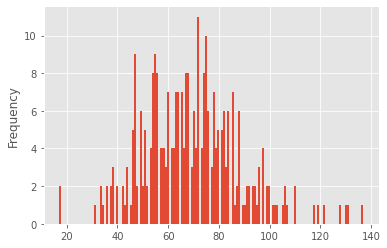

In [25]:
to_cluster.visit_length_minutes.plot.hist(bins=150)

In [26]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = rs.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,AF_visit_length_minutes,HFA_visit_length_minutes,OCT_visit_length_minutes,ORA_visit_length_minutes,visit_length_minutes
Patient,,,,,,,,,,
G1228,0.0000,1.0000,0.0000,0.0000,0.0000,-0.2597,-0.2593,0.0000,-0.0952,0.5139
G1229,0.0000,1.0000,0.0000,0.0000,0.0000,5.8442,0.0370,-0.3158,-0.0476,0.7066
G1230,0.0000,1.0000,0.0000,0.0000,0.0000,-0.1299,0.2222,0.3684,-0.0476,0.1499
G1232,0.0000,1.0000,0.0000,0.0000,0.0000,-0.2597,0.0000,0.4211,-0.0476,-0.1713
G1234,0.0000,1.0000,0.0000,0.0000,0.0000,-0.1299,0.1852,0.0000,0.3333,0.1499


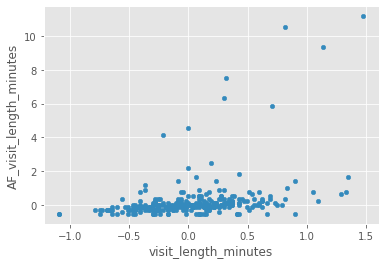

In [27]:
normed.plot.scatter(x='visit_length_minutes', y='AF_visit_length_minutes')

In [28]:
from sklearn.cluster import KMeans

In [29]:
k_cluster = 4
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

KMeans(n_clusters=4, random_state=1)

In [30]:
noWFdf_dummies['Kmeans_Cluster'] = kmeans_method.labels_

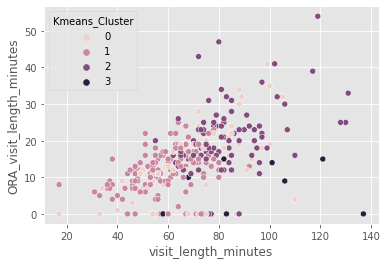

In [31]:
sns.scatterplot(data=noWFdf_dummies, x="visit_length_minutes", y="ORA_visit_length_minutes", hue="Kmeans_Cluster")

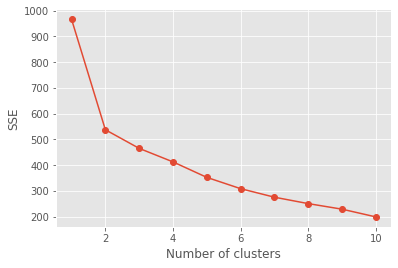

In [32]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(normed)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [33]:
k_cluster = 3
random_seed = 100
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)
noWFdf_dummies['Kmeans_Cluster'] = kmeans_method.labels_

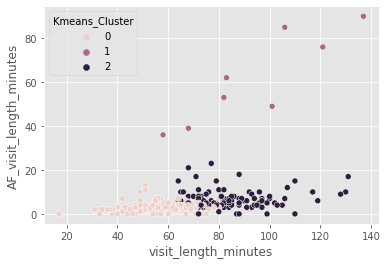

In [34]:
sns.scatterplot(data=noWFdf_dummies, x="visit_length_minutes", y="AF_visit_length_minutes", hue="Kmeans_Cluster")